In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import plotly.express as px

from scipy.stats import pearsonr, spearmanr

sc.settings.set_verbosity=3
sc.set_figure_params(figsize=(3,3))

import sf_utils

from statannotations.Annotator import Annotator
from matplotlib.ticker import FormatStrFormatter,MaxNLocator

from scipy.stats import mannwhitneyu

In [202]:
adata=sc.read_h5ad("./final_objs/cc_regressed_intobj_cr_aggr.h5ad")

In [12]:
adata.obs.seurat_clusters_old = adata.obs.seurat_clusters_old.astype("category")

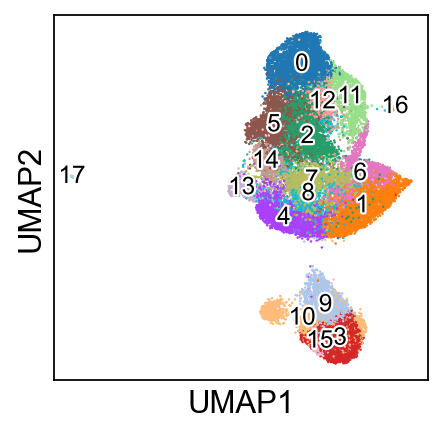

In [21]:
fig=plt.figure(figsize=(3,3))
ax=plt.axes()
sc.pl.umap(adata, color='seurat_clusters_old', legend_loc="on data", title="",
           legend_fontoutline=2, legend_fontsize=11, ax=ax, show=False)
plt.savefig("./Plots/integrated_umap_seurat.pdf", dpi=300)

In [201]:
adata.uns['sample_colors'][0] = '#414487'
adata.uns['sample_colors'][1] = '#8c2981'
adata.uns['sample_colors'][2] = '#fe9f6d'
adata.uns['sample_colors'][3] = '#5ec962'

adata.uns['fate_coarse_colors'][0] = '#e5550d'
adata.uns['fate_coarse_colors'][1] = '#d3d3d3'
adata.uns['fate_coarse_colors'][2] = '#756bb1'
adata.uns['fate_coarse_colors'][3] = '#d3d3d3'

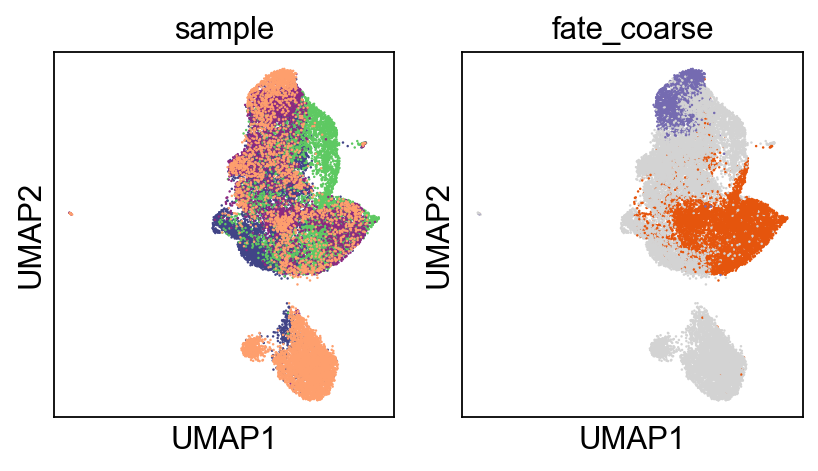

In [203]:
#plot umap by sample and by fate annots
fig=plt.figure(figsize=(6,3))
gs=GridSpec(1,2)

for i,j in zip(gs, ['sample','fate_coarse']):
    ax=plt.subplot(i)
    sc.pl.umap(adata, color=j, ax=ax, show=False,  sort_order=False, legend_loc=None)
    
# plt.tight_layout()
fig.savefig("./Plots/intobj_umap_sample_fates.pdf", dpi=300)

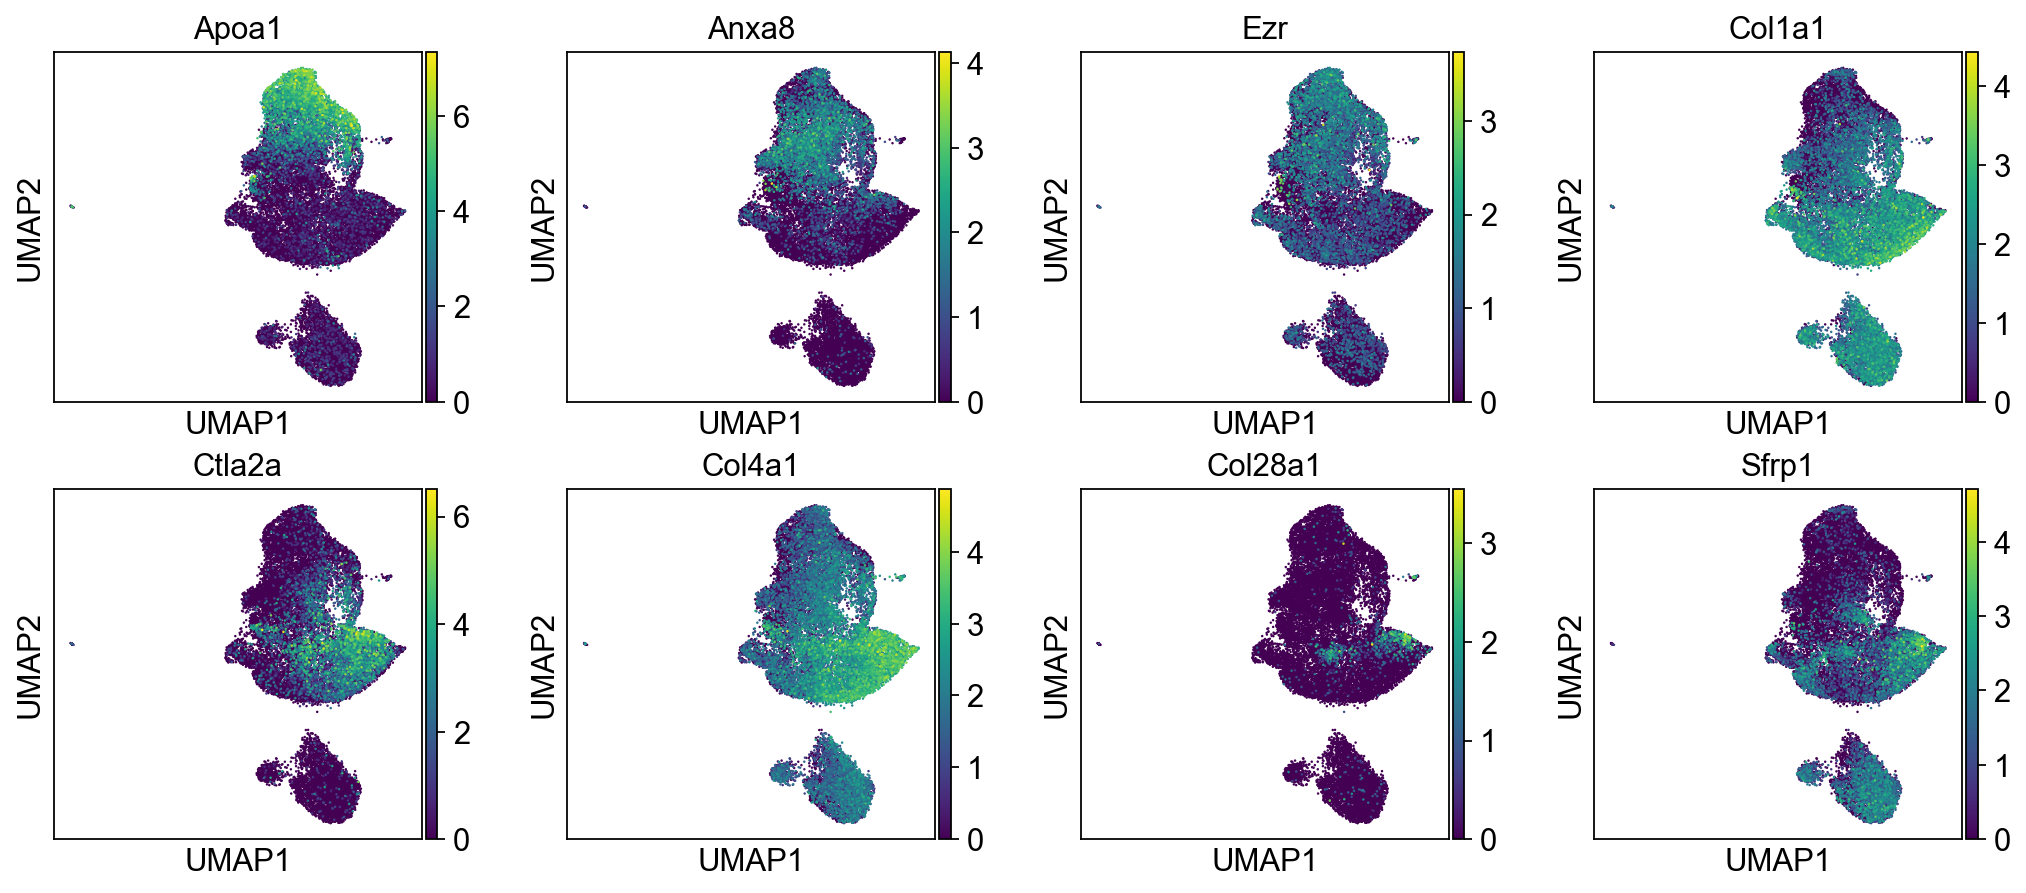

In [44]:
sc.pl.umap(adata, color=['Apoa1','Anxa8','Ezr','Col1a1','Ctla2a','Col4a1','Col28a1','Sfrp1'])

In [59]:
net_ct = adata.obs['sample'].value_counts()
net_ct = net_ct.loc[['zfp_kd',"shc","zfp_oe","empty_oe"]]
sub_ct = adata.obs.loc[adata.obs.seurat_clusters_old.isin([10,9,15,3]),'sample'].value_counts()
sub_ct = sub_ct[net_ct.index].copy()

In [62]:
sub_ct

zfp_kd      0.622434
shc         0.006874
zfp_oe      0.001047
empty_oe    0.057599
Name: sample, dtype: float64

In [159]:
zfp_expr = pd.DataFrame(adata.raw.X[:, adata.raw.var_names=='Zfp281'].todense(), index=adata.raw.obs_names, columns=['Zfp281'])
zfp_expr = zfp_expr.merge(adata.obs[['stalled']], right_index=True, left_index=True).copy()

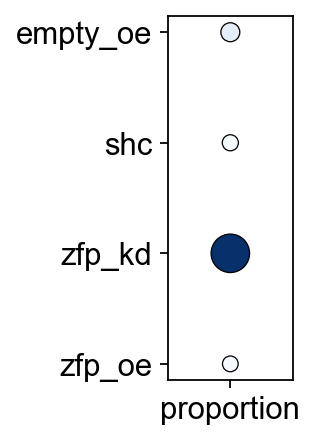

In [80]:
plt.figure(figsize=(1,3))
sns.scatterplot(x = 4*['proportion'],y = sub_ct.index, size=sub_ct.values, legend=False,
                sizes=(50,300), c=sub_ct.values, cmap="Blues", edgecolor='black')

plt.grid(False)
plt.savefig("./Plots/abundance_in_stalled.pdf")

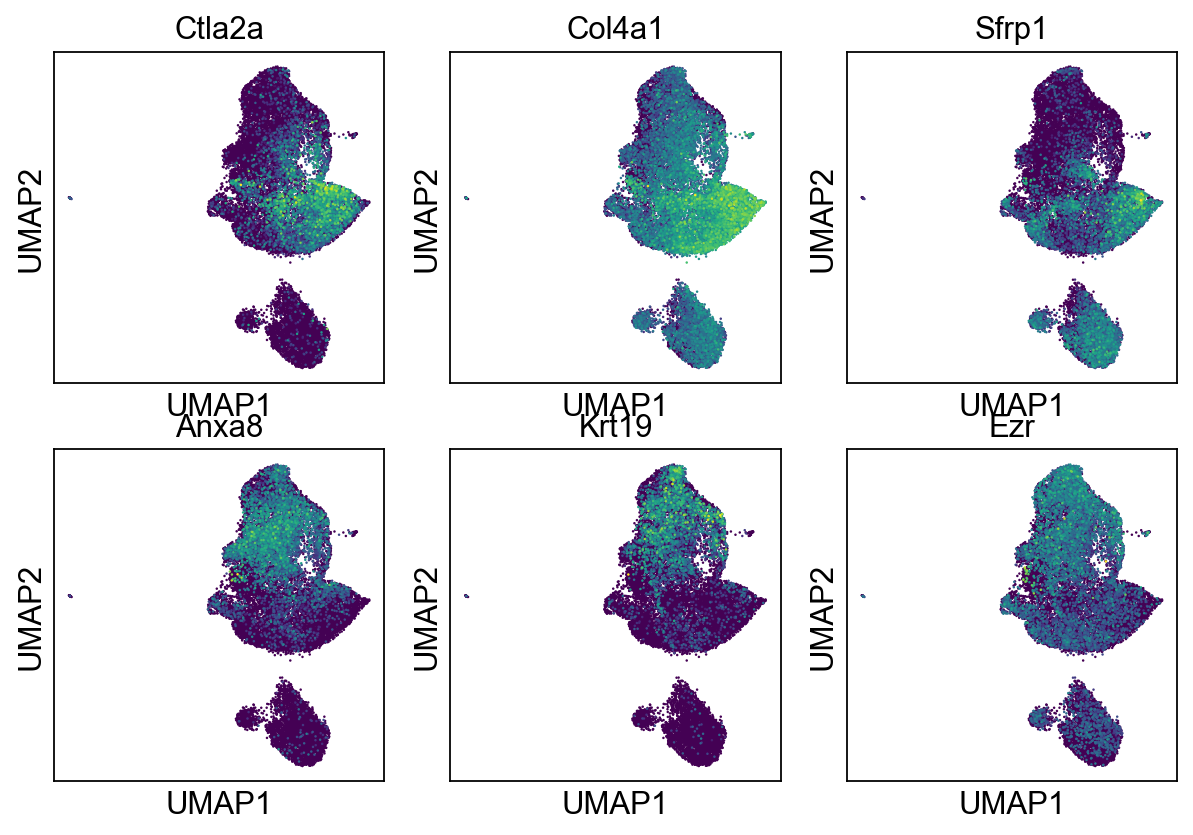

In [8]:
fig=plt.figure(figsize=(9,6))
gs=GridSpec(2,3)

# mapper = {'deadend':'Dead-end','mef':'Fibroblast','reprogram':'iEP'}

for i,j in zip(gs, ["Ctla2a","Col4a1","Sfrp1","Anxa8","Krt19","Ezr"]):
    ax=plt.subplot(i)
    sc.pl.umap(adata, color=j, title=j ,colorbar_loc=None, ax=ax, show=False)
    
fig.savefig("./Plots/integrated_umap_markers.pdf", dpi=300)

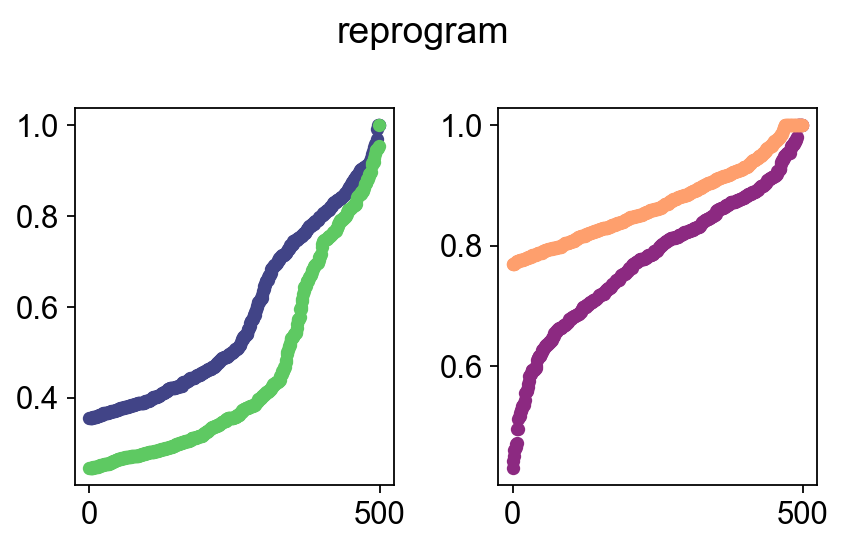

In [291]:
#within reprogramming cluster zfp high has significantly more dead-end identity
fig=plt.figure(figsize=(5.5,3.5))
gs=GridSpec(1,2)

fate = 'reprogram'


ax=plt.subplot(gs[0])
data_curr = plot_data_sub[plot_data_sub['sample']=='empty_oe'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'],ax=ax, color='#414487', linewidth=0, label='Control')

data_curr = plot_data_sub[plot_data_sub['sample']=='zfp_oe'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'], ax=ax, legend=True, color='#5ec962', linewidth=0,label='Zfp281 OE')
plt.grid(False)
plt.ylabel("")
ax.get_legend().remove()
plt.xticks(ticks=(0,500))

ax=plt.subplot(gs[1])
data_curr = plot_data_sub[plot_data_sub['sample']=='shc'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'],ax=ax, color='#8c2981', linewidth=0, label='Control')

data_curr = plot_data_sub[plot_data_sub['sample']=='zfp_kd'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'], ax=ax, legend=True, color='#fe9f6d', linewidth=0,label='Zfp281 KD')
plt.grid(False)
plt.ylabel("")
ax.get_legend().remove()
plt.xticks(ticks=(0,500))


plt.suptitle(fate)
plt.tight_layout()

fig.savefig("./Plots/capy_dotplot_reprogram_id.pdf")

In [292]:
mannwhitneyu(plot_data_sub[plot_data_sub['sample']=='empty_oe'][f'frxn_cell.type_cluster_{fate}'],plot_data_sub[plot_data_sub['sample']=='zfp_oe'][f'frxn_cell.type_cluster_{fate}'])

MannwhitneyuResult(statistic=4378255.5, pvalue=1.0672000782567906e-53)

In [293]:
mannwhitneyu(plot_data_sub[plot_data_sub['sample']=='shc'][f'frxn_cell.type_cluster_{fate}'],plot_data_sub[plot_data_sub['sample']=='zfp_kd'][f'frxn_cell.type_cluster_{fate}'])

MannwhitneyuResult(statistic=997263.0, pvalue=2.1877237406343242e-58)

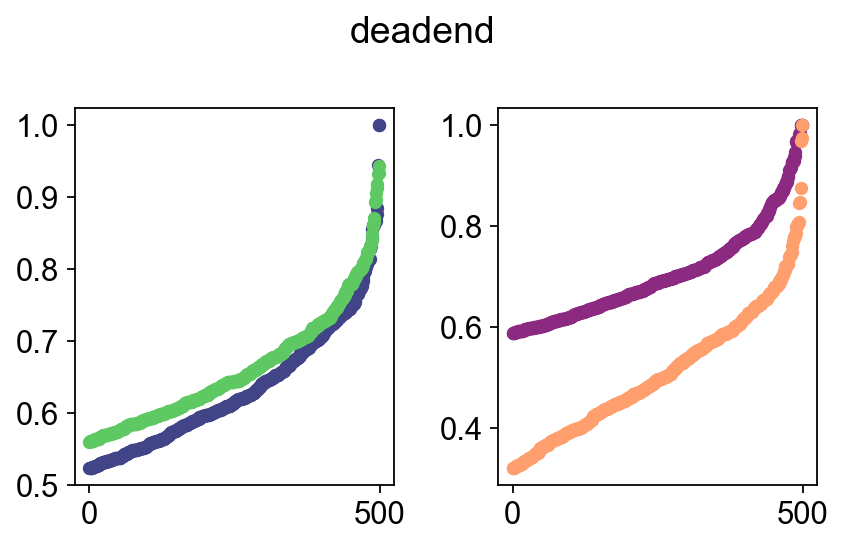

In [295]:
#within reprogramming cluster zfp high has significantly more dead-end identity
fig=plt.figure(figsize=(5.5,3.5))
gs=GridSpec(1,2)

fate = 'deadend'


ax=plt.subplot(gs[0])
data_curr = plot_data_sub[plot_data_sub['sample']=='empty_oe'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'],ax=ax, color='#414487', linewidth=0, label='Control')

data_curr = plot_data_sub[plot_data_sub['sample']=='zfp_oe'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'], ax=ax, legend=True, color='#5ec962', linewidth=0,label='Zfp281 OE')
plt.grid(False)
plt.ylabel("")
ax.get_legend().remove()
plt.xticks(ticks=(0,500))

ax=plt.subplot(gs[1])
data_curr = plot_data_sub[plot_data_sub['sample']=='shc'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'],ax=ax, color='#8c2981', linewidth=0, label='Control')

data_curr = plot_data_sub[plot_data_sub['sample']=='zfp_kd'].sort_values(f'frxn_cell.type_cluster_{fate}').tail(500)
sns.scatterplot(x=list(range(500)), y=data_curr[f'frxn_cell.type_cluster_{fate}'], ax=ax, legend=True, color='#fe9f6d', linewidth=0,label='Zfp281 KD')
plt.grid(False)
plt.ylabel("")
ax.get_legend().remove()
plt.xticks(ticks=(0,500))


plt.suptitle(fate)
plt.tight_layout()
fig.savefig("./Plots/capy_dotplot_deadend_id.pdf")

In [296]:
mannwhitneyu(plot_data_sub[plot_data_sub['sample']=='empty_oe'][f'frxn_cell.type_cluster_{fate}'],plot_data_sub[plot_data_sub['sample']=='zfp_oe'][f'frxn_cell.type_cluster_{fate}'])

MannwhitneyuResult(statistic=3138316.5, pvalue=1.1058872723774906e-11)

In [297]:
mannwhitneyu(plot_data_sub[plot_data_sub['sample']=='shc'][f'frxn_cell.type_cluster_{fate}'],plot_data_sub[plot_data_sub['sample']=='zfp_kd'][f'frxn_cell.type_cluster_{fate}'])

MannwhitneyuResult(statistic=2133127.5, pvalue=3.260014327465937e-120)

In [263]:
#fold change in number of fate converted cells between samples
cell_tally = pd.crosstab(adata.obs.fate, adata.obs['sample']).T

cell_tally['conv'] = cell_tally['dead-end'] + cell_tally['reprogramming']
cell_tally['total'] = cell_tally['dead-end'] + cell_tally['reprogramming'] + cell_tally['none']
cell_tally['conv'] = cell_tally['conv']/cell_tally['total']
cell_tally = cell_tally['conv']

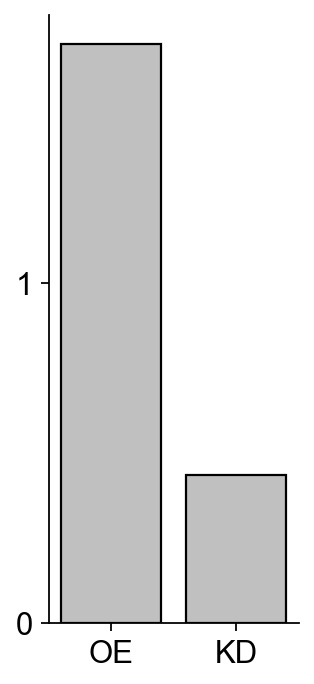

In [284]:
fig=plt.figure(figsize=(2,5))
ax=plt.axes()
sns.barplot(x=['OE','KD'], y = [cell_tally['zfp_oe']/cell_tally['empty_oe'],cell_tally['zfp_kd']/cell_tally['shc']], color='silver', edgecolor='black')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=1))
plt.grid(False)
plt.savefig("./Plots/oe_kd_foldchange.pdf")

In [3]:
new_mod_scores = pd.read_csv("./inter_files_rev1/lineage_by_day_marker_module_scores.csv", index_col=0)

In [4]:
new_mod_scores.columns = new_mod_scores.columns.map(lambda x:x.replace('reprogramming1','Reprogramming1'))

In [5]:
adata.obs.drop(columns=new_mod_scores.columns, inplace=True)

In [6]:
adata.obs = adata.obs.merge(new_mod_scores, right_index=True, left_index=True)

In [7]:
meta = adata.obs.copy()
meta['stalled'] = meta['stalled'].astype('str')
meta.loc[meta['stalled']=='yes','stalled'] = 'stalled'
meta.loc[meta['fate']=='dead-end','stalled'] = 'dead-end'
meta.loc[meta['fate']=='reprogramming','stalled'] = 'reprogramming'
meta_sub = meta[meta['stalled']!='non-stalled'].copy()

In [8]:
meta_sub.stalled.unique()

array(['dead-end', 'stalled', 'reprogramming'], dtype=object)

In [9]:
PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth':0.8},
    'medianprops':{'color':'black', 'linewidth':0.8},
    'whiskerprops':{'color':'black', 'linewidth':0.8},
    'capprops':{'color':'black', 'linewidth':0.8},
    'flierprops':{'marker': 'o', 'markersize': 5, 'markerfacecolor': 'white','linewidth':1/2}
}

In [13]:
meta_sub['stalled'].value_counts()

dead-end         7069
stalled          4726
reprogramming    1706
Name: stalled, dtype: int64

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dead-end vs. stalled: Mann-Whitney-Wilcoxon test two-sided, P_val:2.214e-236 U_stat=2.265e+07
stalled vs. reprogramming: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.208e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

dead-end vs. stalled: Mann-Whitney-Wilcoxon test two-sided, P_val:9.128e-158 U_stat=2.155e+07
stalled vs. reprogramming: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=7.560e+06


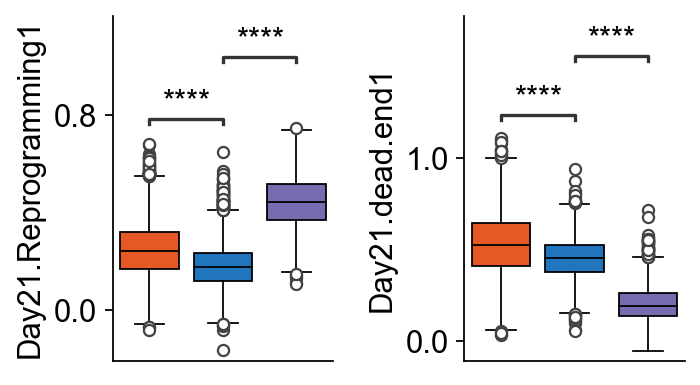

In [10]:
fig = plt.figure(figsize=(9,5))
gs=GridSpec(2,4)

grp = 'MEF1'
grp = 'Day21.Reprogramming1'
grps = new_mod_scores.columns

# fig=plt.figure(figsize=(4,4))
# ax=plt.axes()

for i,j in zip(gs, ['Day21.Reprogramming1','Day21.dead.end1']):
    ax=plt.subplot(i)
    sns.boxplot(x='stalled',y=j, data=meta_sub, saturation=1,**PROPS,palette=['#e45925','#2075bc','#766cb0'])
    plt.grid(False)


    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.xticks([],rotation=90)
    plt.xlabel("")
    # plt.yscale('log')

    pairs=[("stalled", "dead-end"),("stalled", "reprogramming")]
    # pairs=[("yes","no")]
    x='stalled'
    y=j
    annotator = Annotator(ax, pairs, data=meta_sub, x=x, y=y)
    annotator.configure(test='Mann-Whitney', text_format
                        ='star', loc='inside', show_test_name=False)
    annotator.apply_and_annotate()

plt.tight_layout()

plt.savefig("./Plots_rev1/stalled_Day21_marker_modscore_boxplot_rev1.pdf")

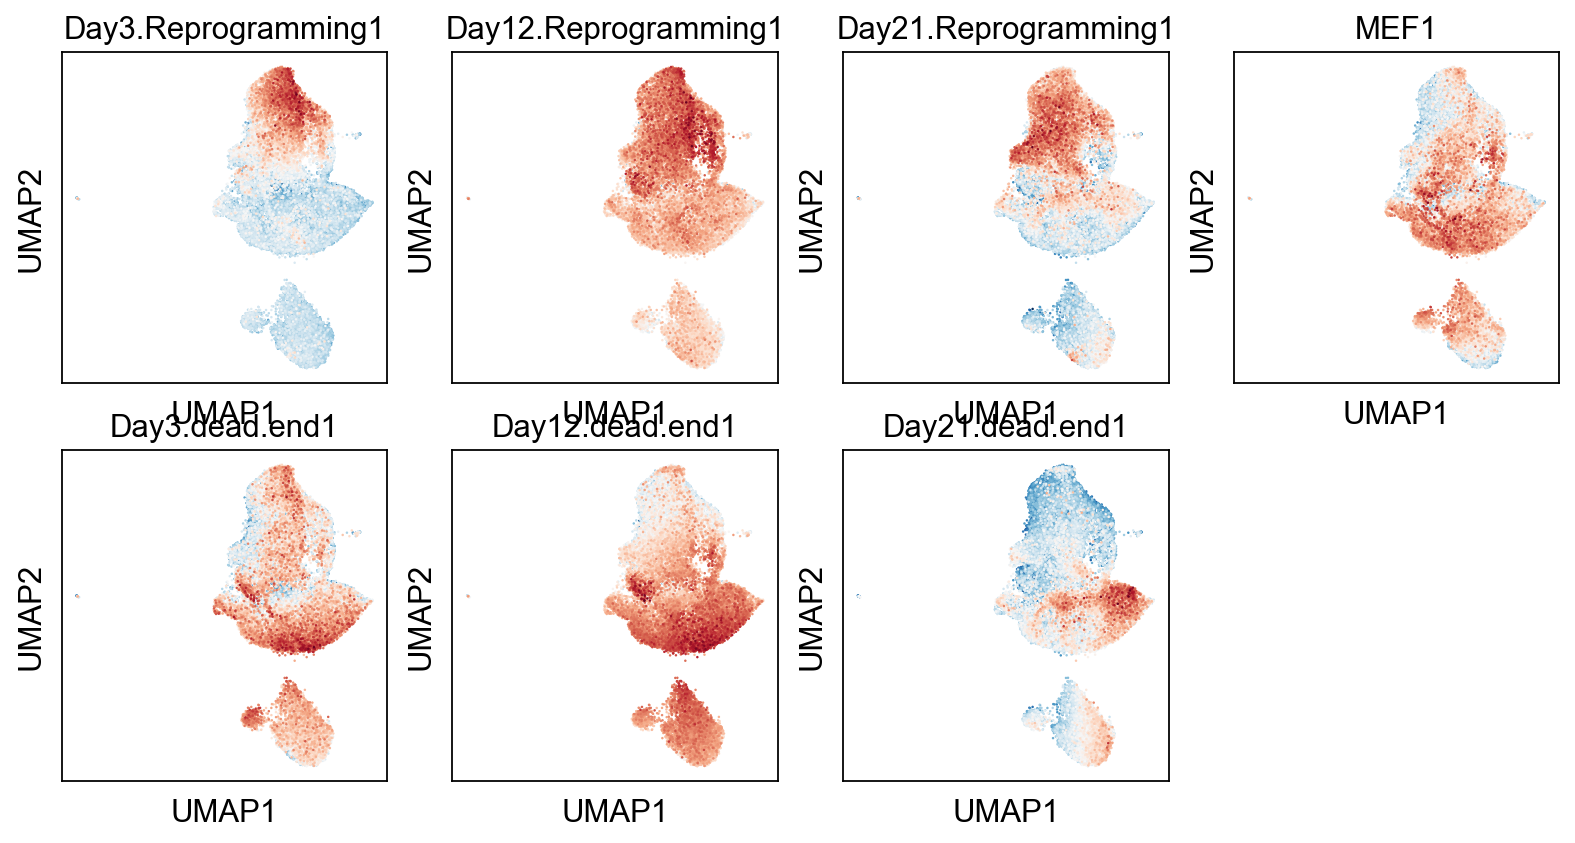

In [73]:
fig=plt.figure(figsize=(12,6))
gs=GridSpec(2,4)


for i,j in zip(gs, grps[[0,2,4,6,1,3,5]]):
    ax=plt.subplot(i)
    sc.pl.umap(adata, color=j, cmap="RdBu_r", colorbar_loc=None, ax=ax, show=False)
# plt.tight_layout()
plt.savefig("./Plots_rev1/lineage_by_day_marker_mod_scores_umap.pdf", dpi=300)